# Modèles d'apprentissage

__[III Modèles Linéaires](#III-Modèles-Linéaires)__\
[III.1 Régression linéaire simple avec toutes les variables](#III.1-Régression-linéaire-simple-avec-toutes-les-variables)\
[III.2 Ridge](#III.2-Ridge)\
[III.3 Lasso](#III.3-Lasso)

__[IV kNN](#IV-kNN)__

__[V SVM](#V-SVM)__

__[VI Modèles non-linéaires](#VI-Modèles-non-linéaires)__\
[VI.1 SVM à noyau](#VI.1-SVM-à-noyau)

__[VII Méthodes ensemblistes](#VII-Méthodes-ensemblistes)__\
[VII.1 Forêts aléatoires](#VII.1-Forêts-aléatoires)\
[VII.2 GradientBoostingRegressor](#VII.2-GradientBoostingRegressor)

__[VIII Choix du modèle](#VIII-Choix-du-modèle)__



In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import missingno as msno

# III Modèles
## III.1 Régressions Linéaires

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.pipeline import Pipeline
from sklearn import set_config

set_config(display='diagram')

Chargement des modèles

In [13]:
modele1 = pd.read_csv("./modele1.csv")
modele2 = pd.read_csv("./modele2.csv")

modele1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6209 entries, 0 to 6208
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   DataYear                      6209 non-null   int64  
 1   BuildingType                  6209 non-null   object 
 2   PrimaryPropertyType           6209 non-null   object 
 3   Address                       6209 non-null   object 
 4   CouncilDistrictCode           6209 non-null   int64  
 5   Neighborhood                  6209 non-null   object 
 6   YearBuilt                     6209 non-null   int64  
 7   NumberofBuildings             6209 non-null   object 
 8   NumberofFloors                6209 non-null   object 
 9   LargestPropertyUseType        6209 non-null   object 
 10  SecondLargestPropertyUseType  6209 non-null   object 
 11  ThirdLargestPropertyUseType   6209 non-null   object 
 12  ENERGYSTARScore               4739 non-null   float64
 13  Sit

In [14]:
modele2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6209 entries, 0 to 6208
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   DataYear                6209 non-null   int64  
 1   BuildingType            6209 non-null   object 
 2   PrimaryPropertyType     6209 non-null   object 
 3   CouncilDistrictCode     6209 non-null   int64  
 4   NumberofFloors          6209 non-null   object 
 5   LargestPropertyUseType  6209 non-null   object 
 6   ENERGYSTARScore         4739 non-null   float64
 7   SiteEnergyUse           6209 non-null   float64
 8   SteamUse(kBtu)          6209 non-null   float64
 9   Electricity(kBtu)       6209 non-null   float64
 10  NaturalGas(kBtu)        6209 non-null   float64
 11  TotalGHGEmissions       6209 non-null   float64
 12  SiteEnergyUse_log       6209 non-null   float64
 13  TotalGHGEmissions_log   6209 non-null   float64
 14  Electricity_ratio       6209 non-null   

In [15]:
df = modele1.drop(columns=["ENERGYSTARScore"])

# Sélection des cibles
targets = ["SiteEnergyUse(kBtu)",
           "SiteEnergyUse_log",
           "TotalGHGEmissions", 
           "TotalGHGEmissions_log"]

# retrait des colonnes liées à la consommation d'énergie
energy_type = ["SiteEnergyUseWN(kBtu)", 
               "SteamUse(kBtu)",
               "Electricity(kBtu)",
               "NaturalGas(kBtu)", 
               #"Electricity_ratio", 
               #"NaturalGas_ratio", 
               #"Steam_ratio"
              ]

# Sélection des variables
features = [col for col in df.columns if (col not in targets) and (col not in energy_type)]

# Séparation des variables en types "category" et "float64"
df[["NumberofBuildings", "NumberofFloors"]] = df[["NumberofBuildings", 
                                                  "NumberofFloors"]].astype("object")

# Séparation des variables en types "category" et "float64"
#df[["PropertyGFATotal"]] = df[["PropertyGFATotal"]].astype("float64")


cat_cols = df.dtypes[(df.dtypes=="int64") | (df.dtypes=="object")].index
df[cat_cols] = df[cat_cols].astype("category")
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6209 entries, 0 to 6208
Data columns (total 26 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   DataYear                      6209 non-null   category
 1   BuildingType                  6209 non-null   category
 2   PrimaryPropertyType           6209 non-null   category
 3   Address                       6209 non-null   category
 4   CouncilDistrictCode           6209 non-null   category
 5   Neighborhood                  6209 non-null   category
 6   YearBuilt                     6209 non-null   category
 7   NumberofBuildings             6209 non-null   category
 8   NumberofFloors                6209 non-null   category
 9   LargestPropertyUseType        6209 non-null   category
 10  SecondLargestPropertyUseType  6209 non-null   category
 11  ThirdLargestPropertyUseType   6209 non-null   category
 12  SiteEnergyUse(kBtu)           6209 non-null   fl

In [16]:
df[features].head()

,DataYear,BuildingType,PrimaryPropertyType,Address,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,Electricity_ratio,NaturalGas_ratio,Steam_ratio,F1,F2,F3,F4
0,2015,NonResidential,Hotel,way,7,DOWNTOWN,3,1.0,Other,Hotel,None,None,0.527995,0.182253,0.289773,-0.229415,0.378345,0.148800,-0.121410
1,2015,NonResidential,Hotel,street,7,DOWNTOWN,10,1.0,Other,Hotel,Parking,Restaurant,0.467477,0.532542,0.000000,0.175392,-0.187387,0.018060,-0.135515
2,2015,NonResidential,Hotel,avenue,7,DOWNTOWN,7,1.0,Other,Hotel,Parking,Other,0.680459,0.050730,0.268839,7.214426,3.288951,1.179470,1.017279
3,2015,NonResidential,Hotel,street,7,DOWNTOWN,9,1.0,Other,Hotel,Parking,Other,0.409077,0.590940,0.000000,0.775598,-0.309767,-0.198389,1.123551
4,2015,Nonresidential COS,Other,street,7,DOWNTOWN,10,1.0,2.0,Other,None,None,0.603303,0.396722,0.000000,0.051260,-0.053909,-0.725997,-0.528541


## III.1 Régression linéaire simple avec toutes les variables

In [17]:
def print_lr(target, features, df):
    
    # One-hot encoding of categorical variable
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')
    
    # Standard scaling of numerical features
    numeric_transformer = StandardScaler()
    
    preprocessor = ColumnTransformer(
        transformers=[
            ("esc", "passthrough", ["F1", "F2", "F3", "F4"]),
            ('num', numeric_transformer, selector(dtype_exclude="category")),
            ('cat', categorical_transformer, selector(dtype_include="category"))
        ])
    
    # Append regressor to preprocessing pipeline.
    # Now we have a full prediction pipeline.
    reg = Pipeline(steps=[('preprocessor', preprocessor),
                          ('regressor', LinearRegression())])
    
    X = df[features]
    y = df[target]
    
    
    # cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    
    #scores = cross_val_score(reg, X, y, cv=kf)
    cv_results = pd.DataFrame(cross_validate(reg, X, y, cv=kf,
                            scoring=('r2',
                                     #'neg_mean_squared_log_error'
                                    ),
                            return_train_score=True)).sort_values(by="test_r2", ascending=False)
    
    # remplace les valeurs de neg_mean_squared_error, par leurs opposées
    
    #for t in ["train", "test"]:
    #    cv_results[t+"_neg_mean_squared_log_error"] = -cv_results[t+"_neg_mean_squared_log_error"]
    moyenne = pd.DataFrame(data=cv_results.to_numpy().mean(axis=0).reshape(1, -1), 
                           columns=cv_results.columns, 
                           index=["moyenne"])
    cv_results = pd.concat([cv_results, moyenne])
    
    #print("Scores: ", scores)
    #print("Score moyen: {:.2f}".format(np.mean(scores)))
    
    return cv_results

In [18]:
print_lr("SiteEnergyUse_log", features, df)

,fit_time,score_time,test_r2,train_r2
3,0.302934,0.024557,0.652220,0.644086
2,0.314509,0.024654,0.651217,0.644303
1,0.304024,0.024919,0.632006,0.648922
4,0.299130,0.024398,0.631457,0.648667
0,0.324842,0.025283,0.195388,0.678813
moyenne,0.309088,0.024762,0.552458,0.652958


## III.2 Ridge

In [26]:
def print_modelresult(target, features, df, params, model_gs, score, axis_scale="log", plot_param="alpha"):


    # One-hot encoding of categorical variable
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')
    
    # Standard scaling of numerical features
    numeric_transformer = StandardScaler()
    
    preprocessor = ColumnTransformer(
        transformers=[
            ("pca", "passthrough", ["F1", "F2", "F3", 
                                    "F4"
                                   ]),
            ('num', numeric_transformer, selector(dtype_exclude="category")),
            ('cat', categorical_transformer, selector(dtype_include="category"))
        ])
    
    # Append regressor to preprocessing pipeline.
    # Now we have a full prediction pipeline.
    reg = Pipeline(steps=[('preprocessor', preprocessor),
                          ('regressor', model_gs)])
    
    # Séparation prédicteurs - cible
    X = df[features]
    y = df[target]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                        random_state=0)
    
    # Nested cross-validation
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=4)
    
    # Hyperparamètre à optimiser
    param_grid = {}
    for key, values in params.items():
        param_grid["regressor__"+key] = values
        
        
    # Créer une regression Ridge avec sélection d'hyperparamètre par validation croisée
    regr = GridSearchCV(
    reg,            # modèle
    param_grid,     # hyperparamètres à tester
    cv=inner_cv,    # nombre de folds de validation croisée
    scoring=score,   # score à optimiser
    return_train_score=True,
    refit='r2',
    )
    
    # Optimiser cet estimateur sur le jeu d'entraînement
    regr.fit(X_train, y_train)
    
    # Afficher le(s) hyperparamètre(s) optimaux
    print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
    print(regr.best_params_)
    
    # Performance en généralisation du meilleur modèle sur le set de validation
    y_pred = regr.predict(X_test)
    print("\nSur le jeu de test : {:.3f}".format(r2_score(y_test, y_pred)))
    
    # Résultats de la validation croisée
    cv_results = pd.DataFrame(regr.cv_results_)
        
    cv_results = cv_results.sort_values("mean_test_r2", ascending=False)
    
    param_keys = ["param_"+k for k in param_grid.keys()]
    param_cols = []
    for sample in ("train", "test"):
        for i in range(len(score)):
            for s in ("mean", "std"):
                param_cols.append("{}_{}_{}".format(s, sample, score[i]))
        
        # Pour rendre positive l'erreur rmse (négative par défaut avec GridSearch)
        try:
            cv_results["mean_{}_{}".format(sample, score[1])] *= -1
        except:
            pass
        
    param_cols += param_keys
    param_cols += ["mean_fit_time", "std_fit_time", "mean_score_time", "std_score_time"]
    
    # Affiche les scores sur les jeu d'entrainement et de test
    d = cv_results.set_index("param_regressor__{}".format(plot_param))
    cols = []
    for t in ("train", "test"):
        for s in score: 
            cols.append("mean_{}_{}".format(t, s))
            
    sns.lineplot(data=d[cols])
    plt.xscale(axis_scale)
    plt.show()
    
    return cv_results[param_cols], cv_results.iloc[0]
    

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'regressor__alpha': 2.1544346900318843}

Sur le jeu de test : 0.353


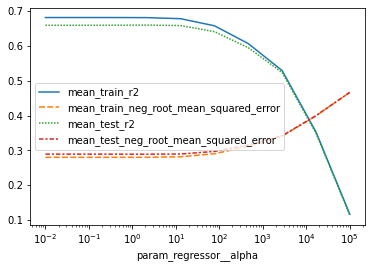

In [28]:
# Valeurs possibles du paramètre alpha
params = {"alpha" : np.logspace(-2, 5, 10)}

# Choisir un score à optimiser et/ou une erreur à minimiser, ici le R2 et le RMSE 
score = ('r2', 'neg_root_mean_squared_error')

# modèle
model = Ridge()

# fit et affichage des résultats
log_ridgeresults, log_ridgebestresult = print_modelresult("SiteEnergyUse_log",
                                                            features,
                                                            df,
                                                            params,
                                                            model,
                                                            score)

## III.3 Lasso

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:515: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2834548048480201, tolerance: 0.08448174351897897
  max_iter, tol, rng, random, positive)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:515: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.10236574445337965, tolerance: 0.0838556798871976
  max_iter, tol, rng, random, positive)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:515: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.10019086389900167, tolerance: 0.0858819778380159
  max_iter, tol, rng, random, positive)


Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'regressor__alpha': 0.00021544346900318823}

Sur le jeu de test : 0.350


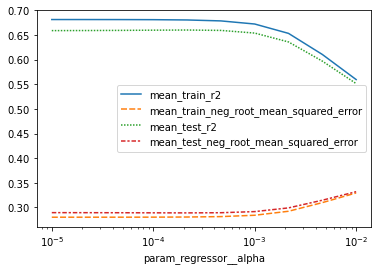

In [21]:
# Valeurs possibles du paramètre alpha
params = {"alpha" : np.logspace(-5, -2, 10)}

# Choisir un score à optimiser et/ou une erreur à minimiser, ici le R2 et le RMSE 
score = ('r2', 'neg_root_mean_squared_error')

# modèle
model = Lasso(max_iter=1e4)

# fit et affichage des résultats
log_lassoresults, log_lassobestresult = print_modelresult("SiteEnergyUse_log",
                                        features,
                                        df,
                                        params,
                                        model,
                                        score)

# IV kNN

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'regressor__n_neighbors': 3}

Sur le jeu de test : 0.741


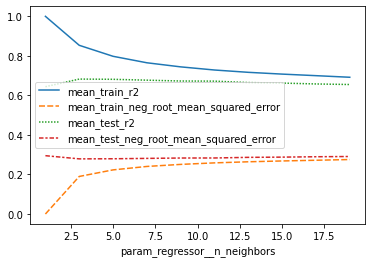

In [22]:
from sklearn.neighbors import KNeighborsRegressor

# Valeurs possibles du nombre de plus proches voisins
params = {"n_neighbors" : [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]}

# Choisir un score à optimiser et/ou une erreur à minimiser, ici le R2 et le RMSE 
score = ('r2', 'neg_root_mean_squared_error')

# modèle
model = KNeighborsRegressor()

# fit et affichage des résultats
log_knnresults, log_knnbestresult = print_modelresult("SiteEnergyUse_log",
                                                        features,
                                                        df,
                                                        params,
                                                        model,
                                                        score,
                                                        axis_scale="linear",
                                                        plot_param="n_neighbors")

# V SVM

In [ ]:
from sklearn.svm import LinearSVR

# Valeurs possibles du paramètre C
params = {"C" : np.logspace(-2, 2, 10)}

# Choisir un score à optimiser et/ou une erreur à minimiser, ici le R2 et le RMSE 
score = ('r2', 'neg_root_mean_squared_error')

# modèle
model = LinearSVR(tol=1e-3, max_iter=1e5, dual=False, loss="squared_epsilon_insensitive")

# fit et affichage des résultats
log_svmresults, log_svm_bestresult = print_modelresult("SiteEnergyUse_log",
                                                       features,
                                                       df,
                                                       params,
                                                       model,
                                                       score,
                                                       plot_param="C")

# VI Modèles non-linéaires

## VI.1 SVM à noyau

In [ ]:
from sklearn.svm import SVR

# Valeurs possibles des hyperparamètres
params = {"C" : np.logspace(-1, 2, 6), "gamma":np.logspace(-2, 0, 4)}

# Choisir un score à optimiser et/ou une erreur à minimiser, ici le R2 et le RMSE 
score = ('r2', 'neg_root_mean_squared_error')

# modèle
model=SVR(tol=1e-3, kernel="rbf")

# fit et affichage des résultats
log_kerlsvmresults, log_kernelsvm_bestresult = print_modelresult("SiteEnergyUse_log",
                                                                 features,
                                                                 df,
                                                                 params,
                                                                 model,
                                                                 score,
                                                                 plot_param="C")

In [ ]:
## Calcul de la matrice de Gram
#kmatrix = metrics.pairwise.rbf_kernel(X_train_std, gamma=regr.best_params_["gamma"])
#kmatrix = print_SVR(quant_var, qualit_var, "SiteEnergyUse_log", d2015, C, gamma, score)
#kmatrix100 = kmatrix[:100, :100]

#sns.heatmap(kmatrix)
#plt.show()

In [ ]:
log_kerlsvmresults

# VII Méthodes ensemblistes

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler

## VII.1 Forêts aléatoires

Premier essai avec l'algorithme RandomForestRegressor sur les mêmes features que précédemment et un nombre d'estimateurs à 100. Le but est à la fois d'obtenir une première estimation par cet algorithme et une mesure des feature_importances dans le but d'optimiser le modèle.

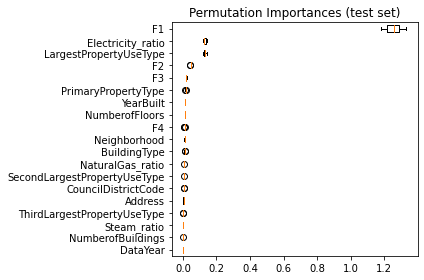

In [24]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

target = "SiteEnergyUse_log"

# One-hot encoding of categorical variable
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Standard scaling of numerical features
numeric_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, selector(dtype_exclude="category")),
        ('cat', categorical_transformer, selector(dtype_include="category"))
    ])

# Append regressor to preprocessing pipeline.
# Now we have a full prediction pipeline.
reg = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', RandomForestRegressor(n_estimators=100, oob_score=True))])

# Séparation prédicteurs - cible
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                        random_state=0)

reg.fit(X_train, y_train)
result = permutation_importance(reg, X_test, y_test, n_repeats=10,
                                random_state=0)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

In [25]:
y_pred = reg.predict(X_test)
print("R2 score: {}".format(r2_score(y_test, y_pred)))

R2 score: 0.8708275058087733


In [ ]:
df_importance = pd.DataFrame(data=result.importances_mean[sorted_idx[::-1]], index=X_test.columns[sorted_idx[::-1]],
             columns=["Importance"])
df_importance

In [ ]:
# seulement les "meilleures" features
features = df_importance.index[:6]

# Valeurs possibles du nombre d'arbres
params = {"n_estimators" : [100, 200, 500, 1000]}

# Choisir un score à optimiser, ici le R2
score = ('r2', 'neg_root_mean_squared_error')

# modèle
model = RandomForestRegressor(oob_score=True)

# fit et affichage des résultats
log_randomforestresults, log_randomforestbestresult = print_modelresult("SiteEnergyUse_log", 
                                                              features,
                                                              df, 
                                                              params,
                                                              model, 
                                                              score, 
                                                              plot_param="n_estimators",
                                                              axis_scale="linear")

In [ ]:
log_randomforestresults

In [ ]:
# One-hot encoding of categorical variable
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Standard scaling of numerical features
numeric_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, selector(dtype_exclude="category")),
        ('cat', categorical_transformer, selector(dtype_include="category"))
    ])

# Séparation prédicteurs - cible
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=0)

# Nested cross-validation
inner_cv = KFold(n_splits=5, shuffle=True, random_state=4)

# Hyperparamètre à optimiser
param_grid = {}
for key, values in params.items():
    param_grid["regressor__"+key] = values
    
    
# Créer une regression Ridge avec sélection d'hyperparamètre par validation croisée
regr = GridSearchCV(
model,            # modèle
param_grid,     # hyperparamètres à tester
cv=inner_cv,    # nombre de folds de validation croisée
scoring=score,   # score à optimiser
return_train_score=True,
refit='r2',
)



X_train = preprocessor.fit_transform(X_train)[feature_names2]

# Optimiser cet estimateur sur le jeu d'entraînement
regr.fit(X_train, y_train)

# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(regr.best_params_)

X_test = preprocessor.transform(X_test)[feature_names2]

# Performance en généralisation du meilleur modèle sur le set de validation
y_pred = regr.predict(X_test)
print("\nSur le jeu de test : {:.3f}".format(r2_score(y_test, y_pred)))

# Résultats de la validation croisée
cv_results = pd.DataFrame(regr.cv_results_)
    
cv_results = cv_results.sort_values("mean_test_r2", ascending=False)

param_keys = ["param_"+k for k in param_grid.keys()]
param_cols = []
for sample in ("train", "test"):
    for i in range(len(score)):
        for s in ("mean", "std"):
            param_cols.append("{}_{}_{}".format(s, sample, score[i]))
    
    # Pour rendre positive l'erreur rmse (négative par défaut avec GridSearch)
    try:
        cv_results["mean_{}_{}".format(sample, score[1])] *= -1
    except:
        pass
    
param_cols += param_keys
param_cols += ["mean_fit_time", "std_fit_time", "mean_score_time", "std_score_time"]

# Affiche les scores sur les jeu d'entrainement et de test
d = cv_results.set_index("param_regressor__{}".format(plot_param))
cols = []
for t in ("train", "test"):
    for s in score: 
        cols.append("mean_{}_{}".format(t, s))

log_randomforestresults, log_randomforestbestresult = cv_results[param_cols], cv_results.iloc[0]

In [ ]:
sns.lineplot(data=d[cols])
plt.xscale(axis_scale)
plt.show()

In [ ]:
from sklearn.feature_selection import SelectFromModel
select = SelectFromModel(reg.named_steps["regressor"], threshold=0.001, prefit=True)
X_train2 = select.transform(preprocessor.transform(X_train))
X_test2 = select.transform(preprocessor.transform(X_test))

reg.named_steps["regressor"].fit(X_train2, y_train)

pred2 = reg.named_steps["regressor"].predict(X_test2)
y_pred2 = reg.named_steps["regressor"].predict(X_test2)
print("R2 score: {}".format(r2_score(y_test, y_pred2)))

In [ ]:
feature_names2 = feature_names[importances>=1e-3]
importances2 = importances[importances>=1e-3]
forest_importances2 = pd.Series(data=importances2, index=feature_names2)

fig, ax = plt.subplots(figsize=(16, 15))
forest_importances2.sort_values().plot.barh(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## VII.2 GradientBoostingRegressor

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

# Valeurs possibles du nombre d'arbres
params = {"n_estimators": [500, 1000, 2000, 4000]}

# Choisir un score à optimiser, et/ou une erreur à minimiser ici le R2 et le RMSE
score = ('r2', 'neg_root_mean_squared_error')

# modèle
model=GradientBoostingRegressor()

# fit et affichage des résultats
log_grboostresults, log_grboostbestresult = print_modelresult("SiteEnergyUse_log", 
                                                              features,
                                                              df, 
                                                              params,
                                                              model, 
                                                              score, 
                                                              plot_param="n_estimators",
                                                              axis_scale="linear")

# VIII Choix du modèle

In [ ]:
index = ["mean_test_r2", "mean_train_r2","mean_test_neg_root_mean_squared_error", "mean_fit_time"]
d = {"Ridge":log_ridgebestresult[index], 
      "Lasso":log_lassobestresult[index],
      "kNN":log_knnbestresult[index],
      "SVM":log_svm_bestresult[index], 
      "SVM Non-linéaire": log_kernelsvm_bestresult[index],
      "randomforest":log_randomforestbestresult[index], 
      "gradient boosting":log_grboostbestresult[index]}
model_1 = pd.DataFrame(data=d)
model_1